<a href="https://colab.research.google.com/github/rameshavinash94/Deep_learning_Scratch/blob/main/Tensor_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WITHOUT HIGH LEVEL API**

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from typing import Callable
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [22]:
class MSE:
  def __call__(self, pred_y, true_y):
    self.pred_y = pred_y
    self.true_y = true_y
    return tf.reduce_mean((pred_y-true_y)**2)
  
  def backward(self):
    n = self.true_y.shape[0]
    self.gradient = 2.0 * (self.pred_y - self.true_y) / n
    return self.gradient

In [23]:
class Linear:
  def __init__(self, input_dim: int, num_hidden:int = 1):
    self.weights = tf.Variable(tf.random.uniform(shape=(input_dim, num_hidden)))
    self.bias = tf.Variable(tf.zeros(shape=(num_hidden, )))

  def __call__(self, X):
    self.X = X
    output = tf.matmul(self.X, self.weights) + self.bias
    return output
  
  def backward(self, gradient):
    self.weights_gradient = tf.matmul(self.X, gradient, transpose_a=True) #matrix multiplication of X.T * gradient
    self.bias_gradient = tf.reduce_sum(gradient, 0)
    self.X_gradient = tf.matmul(gradient, self.weights, transpose_b=True)
    return self.X_gradient

  def update(self, learning_rate):
    self.weights = tf.Variable(self.weights - learning_rate * self.weights_gradient)
    self.bias = tf.Variable(self.bias - learning_rate * self.bias_gradient)

In [24]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = tf.clip_by_value(self.input_, 0, tf.float32.max)
    return self.output

  def backward(self, output_gradient):
    self.input_gradient = tf.cast((self.input_ > 0), tf.float32) * output_gradient
    return self.input_gradient

In [25]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)

  def __call__(self, X):
    l1 = self.linear1(X)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, learning_rate):
    self.linear2.update(learning_rate)
    self.linear1.update(learning_rate)

In [26]:
def fit(X, y, model:Callable, loss:Callable, learning_rate:float, num_epochs):
  for epoch in range(num_epochs):
    pred_y = model(X)
    loss_value = loss(pred_y, y)
    if epoch % 5 == 0:
      print(f'Epoch: {epoch}, Loss: {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(learning_rate)

In [27]:
no_samples, input_dim, output_dim, learning_rate = 500, 3, 2, 0.01 
X = tf.random.uniform((no_samples, input_dim), -1, 1)

weights_true = tf.transpose(tf.constant([[6, 1, 8],[-3, 1, 3]], dtype=tf.float32))
bias_true = tf.constant([[0.5], [1]], dtype=tf.float32)
true_y = tf.matmul(X ** 2, weights_true) + tf.matmul(X, weights_true) + tf.transpose(bias_true)
print(f'X:{X.shape}, y:{true_y.shape}, weights:{weights_true.shape}, bias:{bias_true.shape}')

X:(500, 3), y:(500, 2), weights:(3, 2), bias:(2, 1)


In [28]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

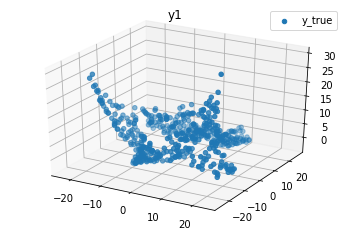

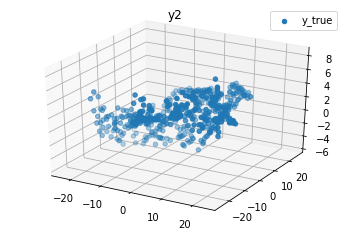

In [29]:
plot_3d('y1', X, true_y[:,0])
plot_3d('y2', X, true_y[:,1])

**WITH HIGH LEVEL API**

In [30]:
def plot_3d(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

In [31]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [32]:
class Linear(keras.layers.Layer):
  def __init__(self, units=32):
      super(Linear, self).__init__()
      self.units = units

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

  def call(self, inputs):
      return tf.matmul(tf.pow(inputs, 2), self.w) + tf.matmul(inputs, self.w) + self.b  


bias_true = tf.constant([1,-1],dtype=tf.dtypes.float32)
x = tf.random.uniform(shape=[100,3], minval=-1., maxval=0.,dtype=tf.dtypes.float32)
weights_1 = tf.transpose(tf.constant([[1, 1,0],[1,0,1]],dtype=tf.dtypes.float32))
weights_2 = tf.transpose(tf.constant([[0,0,1],[0,1,0]],dtype=tf.dtypes.float32))
y_true = tf.matmul(x , weights_1) +  tf.matmul(x , weights_2) + bias_true
X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)

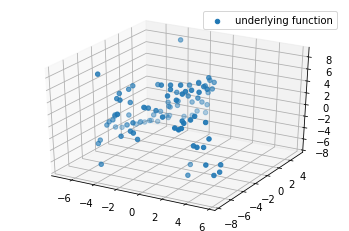

In [34]:
plot_3d(X_embedded, y_embedded)

In [35]:
class MLP(keras.Model):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(3)
        self.linear_2 = Linear(10)
        self.linear_3 = Linear(2)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

mlp = MLP()
y = mlp(x)

Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 4.0257
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 3.4359
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 2.9619
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 2.5429
Epoch 5/10
4/4 [==============================] - 0s 5ms/step - loss: 2.2144
Epoch 6/10
4/4 [==============================] - 0s 5ms/step - loss: 1.9258
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 1.6713
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 1.4540
Epoch 9/10
4/4 [==============================] - 0s 3ms/step - loss: 1.2566
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 1.0860


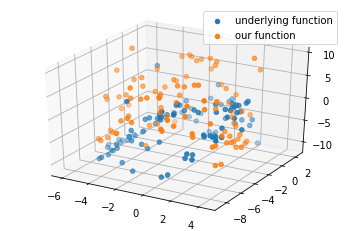

In [36]:
mlp.compile(loss='mse', optimizer=optimizers.SGD(0.02))
mlp.fit(x, y_true, epochs=10)
X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)
y_pred= mlp(x)
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)
plot_3d(X_embedded, y_embedded,y_pred_embedded)

**WITH KERAS DENSE LAYER**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 10)                40        
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
 regression (Dense)          (None, 2)                 14        
                                                                 
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
4/4 [==============================] - 0s 3ms/step - loss: 3.4073
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 2.2817
Epoch 3/10
4/4 [==================

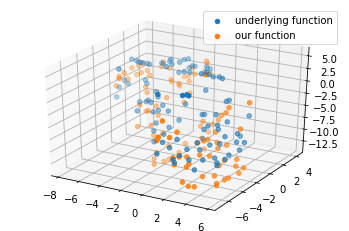

In [37]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

bias_true = tf.constant([1,-1],dtype=tf.dtypes.float32)
x = tf.random.uniform(shape=[100,3], minval=-1., maxval=0.,dtype=tf.dtypes.float32)
weights_1 = tf.transpose(tf.constant([[1, 1,0],[1,0,1]],dtype=tf.dtypes.float32))
weights_2 = tf.transpose(tf.constant([[0,0,1],[0,1,0]],dtype=tf.dtypes.float32))
y_true = tf.matmul(x , weights_1) +  tf.matmul(x , weights_2) + bias_true
X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)


# input layer has 3 neurons for 3 dimensional input
inputs = keras.Input(shape=(3,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
l2 = layers.Dense(6, activation='relu', name='dense_2')(l1)
# output layer has 2 neurons 
outputs = layers.Dense(2, name='regression')(l2)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.02))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)

X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)
y_pred= model(x)
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)
plot_3d(X_embedded, y_embedded,y_pred_embedded)